In [193]:
from cgi import test
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler, scale
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn import decomposition, datasets
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
import pickle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
%matplotlib inline

In [194]:
df=pd.DataFrame(pd.read_excel("diabetes-dataset.xlsx"))

In [195]:
def prepare_data(df):
    print(df.describe)
    corr_mat = df.corr()
    p = df.hist(figsize = (10,10))
    mat_plot(corr_mat)

In [196]:
def mat_plot(corr_mat):
    f,ax = plt.subplots(figsize = (8,6))
    sns.heatmap(corr_mat,cmap = "GnBu",annot = True, fmt = '.1f',ax = ax)
    plt.show()

In [197]:
def preprocess(df):
    diab_df_cpy = df.copy(deep = True)
    diab_df_cpy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']].replace(0,np.NaN)
    diab_df_cpy['Glucose'].fillna(diab_df_cpy['Glucose'].mean(), inplace = True)
    diab_df_cpy['BloodPressure'].fillna(diab_df_cpy['BloodPressure'].mean(), inplace = True)
    diab_df_cpy['SkinThickness'].fillna(diab_df_cpy['SkinThickness'].median(), inplace = True)
    diab_df_cpy['Insulin'].fillna(diab_df_cpy['Insulin'].median(), inplace = True)
    diab_df_cpy['BMI'].fillna(diab_df_cpy['BMI'].median(), inplace = True)
    return diab_df_cpy

In [198]:
def scale_data(diab_df_cpy):
    sc_x = StandardScaler()
    X =  pd.DataFrame(sc_x.fit_transform(diab_df_cpy.drop(["Outcome"],axis = 1),), columns=['Pregnancies', 
'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
    return X


In [199]:
def visualizer(diab_df_cpy):
    fig=px.histogram(diab_df_cpy,x='Age',marginal='violin')
    fig.update_layout(bargap=0.2)
    fig.show()
    sns.countplot(data=diab_df_cpy,x='Outcome',palette='coolwarm')

    fig=px.histogram(diab_df_cpy,x=diab_df_cpy[diab_df_cpy.Outcome==0].Age,marginal='box',title='Age distribution with outcome 0',color_discrete_sequence=['green'])
    fig.update_layout(bargap=0.1)
    fig.show()

    fig=px.histogram(diab_df_cpy,x=diab_df_cpy[diab_df_cpy.Outcome==1].Age,marginal='box',title='Age distribution with outcome 1',color_discrete_sequence=['darkred'])
    fig.update_layout(bargap=0.1)
    fig.show()


    fig = px.box(diab_df_cpy, y="Pregnancies", x="Outcome")
    fig.show()


    plt.subplots(figsize=(15,10))
    sns.boxplot(x='Age', y='BMI', data=diab_df_cpy)
    plt.show()

    data_plot = sns.lmplot('Insulin','Age',data = diab_df_cpy, hue = 'Outcome',fit_reg = 'False')


In [200]:
def split_train_test(diab_df_cpy):

    y = diab_df_cpy.iloc[:,-1:]
    x = diab_df_cpy.iloc[:,:-1]

    X_train,X_test,Y_train,Y_test = train_test_split(x,y,test_size = 0.2,random_state = 8)

    column_lis = list(diab_df_cpy.columns[:-1])

    ### SMOTE ANALYSIS FOR IMBALANCED DATASET
    print("Percentage of Positive Values in training data before Smote :",Y_train.value_counts(normalize=True)[1]/(Y_train.value_counts(normalize=True)[0]+Y_train.value_counts(normalize=True)[1])*100,"%")
    print("Percentage of Negative Values in training data before Smote :",Y_train.value_counts(normalize=True)[0]/(Y_train.value_counts(normalize=True)[0]+Y_train.value_counts(normalize=True)[1])*100,"%")

    smote = SMOTE()
    X_train,Y_train = smote.fit_resample(X_train,Y_train)
    return X_train,Y_train,X_test,Y_test
    #print("Shape of X after SMOTE: ",X_train.shape)

In [201]:
diab_df_cpy = preprocess(df)
diab_df = scale_data(diab_df_cpy)
X_train,Y_train,X_test,Y_test = split_train_test(diab_df_cpy)


Percentage of Positive Values in training data before Smote : 34.3125 %
Percentage of Negative Values in training data before Smote : 65.6875 %


In [202]:
diab_df.head()

Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0    -0.515394  0.524960      -0.870852       0.631010 -0.177601  0.132630   
1    -1.120495 -1.244054       0.803273       0.192542 -0.189864  0.772550   
2    -1.120495  0.754277       0.000000      -0.026692 -0.177601  1.607229   
3    -1.120495  0.426682      -0.368614       1.398329  1.343080  1.342914   
4    -0.817945  0.557720      -0.870852       1.288712  4.163696  1.120333   

   DiabetesPedigreeFunction       Age  
0                 -1.063246  1.180424  
1                 -0.735551 -0.856326  
2                  0.491759 -0.177409  
3                 -0.327478 -0.771462  
4                  0.201161 -1.026055

In [203]:
def dtree_classifier():
    column_lis = X_train.columns
    dtree = DecisionTreeClassifier(max_depth = 15,random_state = 0, 
                                min_samples_split = 2)
    dtree = dtree.fit(X_train,Y_train)
    Y_pred = dtree.predict(X_test)
    #Change using streamlit lib
    accu_score_dtree = metrics.accuracy_score(Y_test,Y_pred)*100
    print("Accuracy Score = {}".format(accu_score_dtree))
    vis_dtree(dtree,Y_pred)
    pickle_dt = open("dtree_classifier.pkl",mode = "wb")
    pickle.dump(dtree,pickle_dt)
    pickle_dt.close()
    return accu_score_dtree

In [204]:
X_train

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
0               2  122.000000      52.000000      43.000000  158.000000   
1               6  105.000000      70.000000      32.000000   68.000000   
2               1   97.000000      68.000000      21.000000  126.000000   
3               1  118.000000      58.000000      36.000000   94.000000   
4               2  129.000000      72.403665      29.000000  126.000000   
...           ...         ...            ...            ...         ...   
2097            5  188.813822      62.696755      33.000000  331.236957   
2098            5  166.000000      76.000000      29.000000  126.000000   
2099           11  136.000000      84.000000      35.000000  130.000000   
2100            2  111.063800      82.601075      32.034587  123.398925   
2101            0  145.000000      72.403665      29.000000  126.000000   

            BMI  DiabetesPedigreeFunction  Age  
0     36.200000                  0.816000   28  
1     30.800000                  0.122000   37  
2     27.200000                  1.095000   22  
3     33.300000                  0.261000   23  
4     38.500000                  0.304000   41  
...         ...                       ...  ...  
2097  31.451340                  0.605621   29  
2098  45.700000                  0.340000   27  
2099  28.300000                  0.260000   42  
2100  44.027132                  0.447632   21  
2101  44.200000                  0.630000   31  

[2102 rows x 8 columns]

In [205]:
def vis_dtree(model,Y_pred):
    column_lis = X_train.columns
    conf_mat = confusion_matrix(Y_test,Y_pred)
    plt.figure(figsize = (7,5))
    sns.heatmap(conf_mat,annot = True)
    plt.show()
    plt.figure(figsize = (7,5))
    pd.Series(model.feature_importances_,index = column_lis).plot(kind = 'barh')
    plot_dtree(model,X_train)
    return

In [206]:
def plot_dtree(model_name,train_data):
    fig = plt.figure(figsize=(250,200))
    _ = tree.plot_tree(
        model_name,
        feature_names = train_data.columns,
        class_names = ['NEGATIVE','POSTIVE'],
        filled = True
    )
    fig.savefig("decision_tree.png")
    return

In [207]:
Y_train_arr = Y_train['Outcome'].ravel()

In [208]:
def rf_classifier():
    Y_train_arr = np.array(Y_train['Outcome'])
    rfc = RandomForestClassifier(n_estimators = 500)
    rfc.fit(X_train,Y_train_arr) 
    # Overfitted
    # y_train_rfc = rfc.predict(x_train_scaled)
    # print("TRAINING Accuracy Score = {}".format(metrics.accuracy_score(Y_train,y_train_rfc)))
    rfc_cv = hyper_param_model(rfc)
    print("RFC Score = {}%".format(rfc.score(X_test,Y_test)*100))
    y_pred_rfc = rfc_cv.predict(X_test)
    test_accu_score = metrics.accuracy_score(Y_test,y_pred_rfc)*100
    y_train_rfc = rfc_cv.predict(X_train)
    print("TRAINING Accuracy Score = {}".format(metrics.accuracy_score(Y_train,y_train_rfc)))
    vis_rf(rfc_cv,y_pred_rfc)
    return y_pred_rfc,test_accu_score

In [209]:
def vis_rf(model,y_pred_rfc):
    #Classification Report
    report_rfc = classification_report(Y_test,y_pred_rfc)
    print(report_rfc)
    rfc_cros_valid = hyper_param_model(model)
    y_pred_rfc_cv = rfc_cros_valid.predict(X_test)
    
    print("Accuracy Score:- {}%".format(metrics.accuracy_score(Y_test,y_pred_rfc_cv)*100))

    print("Training Accuracy Score = {}%".format(metrics.accuracy_score(Y_train,rfc_cros_valid.predict(X_train))))
    mat_rfc_cros_valid = confusion_matrix(Y_test,y_pred_rfc_cv)
    print(mat_rfc_cros_valid)
    plt.figure(figsize = (7,5))
    sns.heatmap(mat_rfc_cros_valid,annot = True)
    roc_plot(model)
    pd.Series(rfc_cros_valid.feature_importances_,index = X_train.columns).plot(kind = 'barh')
    return


In [210]:
def roc_plot(model):
    y_pred_prob = model.predict_proba(X_test)[:,1]
    fpr,tpr, thresholds = roc_curve(Y_test,y_pred_prob)
    plt.figure(figsize=(7,10))
    plt.plot([0,1] , [0,1],'k-')
    plt.plot(fpr,tpr,label = 'Knn')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title('ROC Curve')
    plt.show()
    print("Area under ROC/AUC Curve = {}%".format(roc_auc_score(Y_test,y_pred_prob)*100))


In [211]:
def hyper_param_model(model):
    
    param_grid_aug = {
        'n_estimators':[500],
        'max_features':['sqrt','log2'], #range of values ex - 5 to 15
        'max_depth':[27],#[i for i in range (25,30)]
        'max_leaf_nodes': [173], #set to range of values 5 to 15 [i for i in range (150,181)]
        'criterion':['gini'],
        'min_samples_leaf':[1], #NOT create range from 20 to 50 in steps of 5
    }

    Y_train_arr = Y_train['Outcome'].ravel()
    CV_rfc_aug = GridSearchCV(estimator = model,param_grid = param_grid_aug,cv = 5,n_jobs = -1)
    CV_rfc_aug.fit(X_train,Y_train_arr)
    rfc_cros_valid = CV_rfc_aug. best_estimator_
    pickle_rf = open("rf_classifier.pkl",mode = "wb")
    pickle.dump(rfc_cros_valid,pickle_rf)
    pickle_rf.close()
    return rfc_cros_valid

In [212]:
def log_regression():
    log_reg=linear_model.LogisticRegression(max_iter=50000)
    Y_train_arr = Y_train['Outcome'].ravel()
    log_reg.fit(X_train,Y_train_arr)
    log_reg_cv = hyper_logreg(log_reg)
    predicted=log_reg_cv.predict(X_test)
    test_accu_score = metrics.accuracy_score(Y_test,predicted)
    vis_logreg(log_reg,predicted)
    return test_accu_score

In [213]:
def vis_logreg(model,predicted):
    Y_train_arr = Y_train['Outcome'].ravel()

    cf_matrix = confusion_matrix(Y_test,predicted)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
                fmt='.2%', cmap='Blues')
    plt.show()
    
    #Plot results comparison graph
    coeff = list(model.coef_[0])
    labels = list(X_train.columns)
    features = pd.DataFrame()
    features['Features'] = labels
    features['importance'] = coeff
    features.sort_values(by=['importance'], ascending=True, inplace=True)
    features['positive'] = features['importance'] > 0
    features.set_index('Features', inplace=True)
    features.importance.plot(kind='barh', figsize=(11, 6),color = features.positive.map({True: 'blue', False: 'red'}))
    plt.xlabel('Importance')
    log_reg_cv = hyper_logreg(model)
    roc_plot(log_reg_cv)
    pickle_lr = open("logreg.pkl",mode = "wb")
    pickle.dump(log_reg_cv,pickle_lr)
    pickle_lr.close()
    return

In [214]:
def hyper_logreg(model):
    c_space = np.logspace(-1,2,15)
    param_grid = {'solver':['newton-cg', 'lbfgs', 'liblinear'],'C':c_space}
    log_reg_cv = GridSearchCV(model,param_grid,cv = 5)
    log_reg_cv.fit(X_train,Y_train_arr)
    print("Validation Accuracy of improved model = {}".format(log_reg_cv.best_score_))
    return log_reg_cv


In [215]:
diab_df_cpy.iloc[:,-1:]

Outcome
0           1
1           0
2           1
3           1
4           0
...       ...
1995        0
1996        1
1997        0
1998        1
1999        0

[2000 rows x 1 columns]

In [216]:
diab_df_cpy.iloc[:,:-1]

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0               2    138.0      62.000000           35.0    126.0  33.6   
1               0     84.0      82.000000           31.0    125.0  38.2   
2               0    145.0      72.403665           29.0    126.0  44.2   
3               0    135.0      68.000000           42.0    250.0  42.3   
4               1    139.0      62.000000           41.0    480.0  40.7   
...           ...      ...            ...            ...      ...   ...   
1995            2     75.0      64.000000           24.0     55.0  29.7   
1996            8    179.0      72.000000           42.0    130.0  32.7   
1997            6     85.0      78.000000           29.0    126.0  31.2   
1998            0    129.0     110.000000           46.0    130.0  67.1   
1999            2     81.0      72.000000           15.0     76.0  30.1   

      DiabetesPedigreeFunction  Age  
0                        0.127   47  
1                        0.233   23  
2                        0.630   31  
3                        0.365   24  
4                        0.536   21  
...                        ...  ...  
1995                     0.370   33  
1996                     0.719   36  
1997                     0.382   42  
1998                     0.319   26  
1999                     0.547   25  

[2000 rows x 8 columns]

In [217]:
def sv_classifier():
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    print(IQR)
    diab_df_cpy = preprocess(df)
    diab_df_cpy_up = diab_df_cpy[~((diab_df_cpy < (Q1 - 1.5 * IQR)) |(diab_df_cpy > (Q3 + 1.5 * IQR))).any(axis=1)]
    print(diab_df_cpy_up.head())
    y = diab_df_cpy_up.iloc[:,-1:]
    x = diab_df_cpy_up.iloc[:,:-1]
    x_train_svc,x_test_svc,y_train_svc,y_test_svc = train_test_split(x,y,test_size = 0.2,random_state = 8)
    print(x_train_svc)
    # x_train_svc,x_test_svc,y_train_svc,y_test_svc = train_test_split(diab_df_cpy_up,diab_df_cpy_up.iloc[:,-1:],test_size = 0.2,random_state=8)
    # print(x_train_svc)
    diab_df_cpy = scale_data(diab_df_cpy_up)
    y_train_arr_svc = y_train_svc['Outcome'].ravel()
    classifier = SVC(kernel = 'rbf',probability = True)
    classifier.fit(x_train_svc,y_train_arr_svc)
    # Hyperparameter Tuning
    param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
    grid = GridSearchCV(classifier,param_grid,refit = True, verbose = 2)
    grid.fit(x_train_svc,y_train_arr_svc)
    grid_cv = grid.best_estimator_
    grid_prediction = grid_cv.predict(x_test_svc)
    print(grid_prediction)
    mat_svm = confusion_matrix(y_test_svc['Outcome'],grid_prediction)
    plt.figure(figsize = (7,5))
    sns.heatmap(mat_svm,annot = True)
    print(classification_report(y_test_svc['Outcome'],grid_prediction))
    test_accu_score = accuracy_score(y_test_svc['Outcome'], grid_prediction)*100
    # roc_plot(grid_cv)
    pickle_svm = open("svc_classifier.pkl",mode = "wb")
    pickle.dump(grid_cv,pickle_svm)
    pickle_svm.close()
    return test_accu_score


RFC Score = 98.5%
TRAINING Accuracy Score = 1.0
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       265
           1       0.96      1.00      0.98       135

    accuracy                           0.98       400
   macro avg       0.98      0.99      0.98       400
weighted avg       0.99      0.98      0.99       400

Accuracy Score:- 98.5%
Training Accuracy Score = 1.0%
[[259   6]
 [  0 135]]


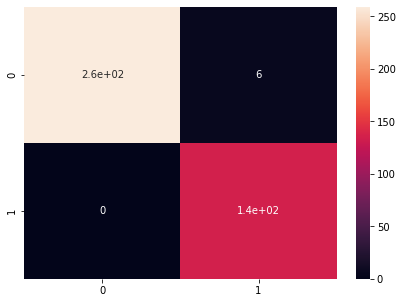

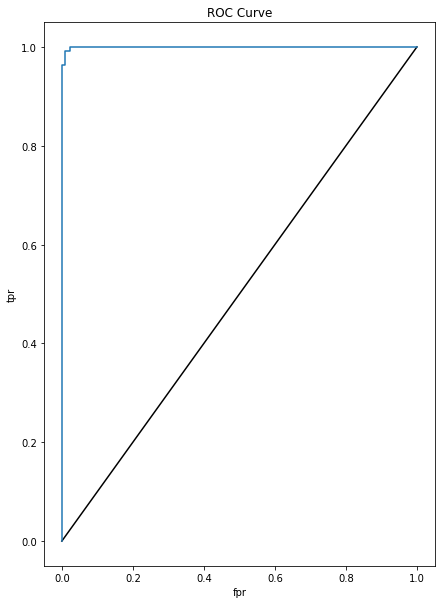

Area under ROC/AUC Curve = 99.96086652690427%


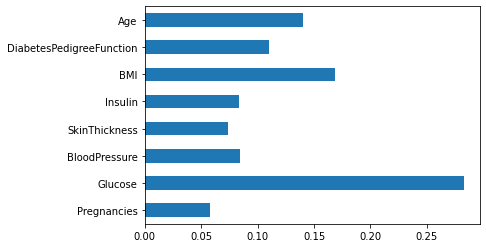

In [218]:
if __name__ == "__main__":
    rf_classifier()

C:\Users\Santosh Vishwanathan\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Santosh Vishwanathan\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Santosh Vishwanathan\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Santosh Vishwanathan\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Santosh Vishwanathan\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algor

Validation Accuracy of improved model = 0.7530856237982129


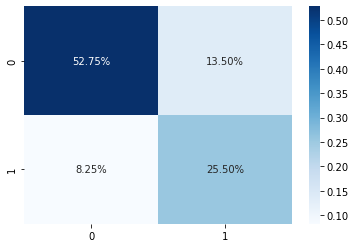

C:\Users\Santosh Vishwanathan\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Santosh Vishwanathan\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Santosh Vishwanathan\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\Santosh Vishwanathan\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\Santosh Vishwanathan\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algor

Validation Accuracy of improved model = 0.7530856237982129


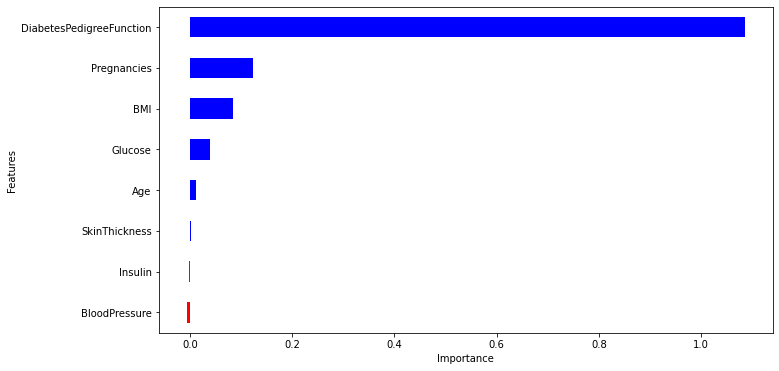

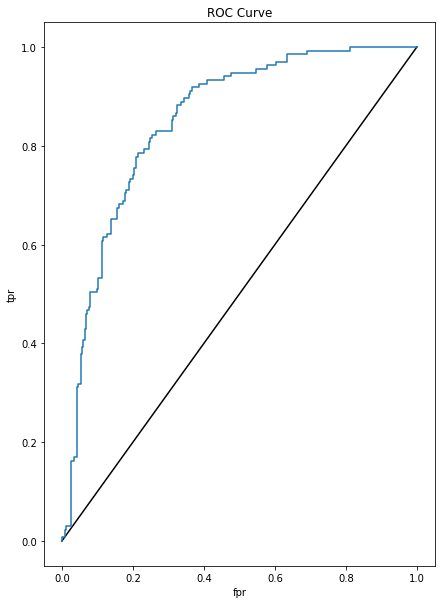

Area under ROC/AUC Curve = 84.9392033542977%


0.7825

In [219]:
log_regression()

In [220]:
diab_df_cpy = preprocess(df)

Pregnancies                   5.000
Glucose                      42.000
BloodPressure                16.500
SkinThickness                32.000
Insulin                     130.000
BMI                           9.425
DiabetesPedigreeFunction      0.380
Age                          16.000
Outcome                       1.000
dtype: float64
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            2    138.0      62.000000           35.0    126.0  33.6   
1            0     84.0      82.000000           31.0    125.0  38.2   
2            0    145.0      72.403665           29.0    126.0  44.2   
3            0    135.0      68.000000           42.0    250.0  42.3   
5            0    173.0      78.000000           32.0    265.0  46.5   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.127   47        1  
1                     0.233   23        0  
2                     0.630   31        1  
3                     0.365   24        1  
5       

99.43019943019942

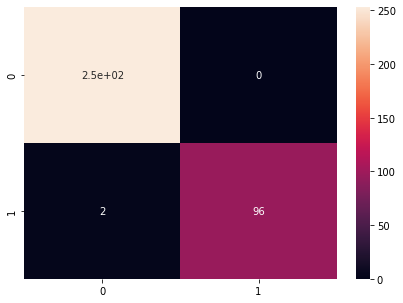

In [221]:
sv_classifier()

In [222]:
pickle_in = open('rf_classifier.pkl','rb')
classifier = pickle.load(pickle_in)

In [223]:
diab_df_cpy

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0               2    138.0      62.000000           35.0    126.0  33.6   
1               0     84.0      82.000000           31.0    125.0  38.2   
2               0    145.0      72.403665           29.0    126.0  44.2   
3               0    135.0      68.000000           42.0    250.0  42.3   
4               1    139.0      62.000000           41.0    480.0  40.7   
...           ...      ...            ...            ...      ...   ...   
1995            2     75.0      64.000000           24.0     55.0  29.7   
1996            8    179.0      72.000000           42.0    130.0  32.7   
1997            6     85.0      78.000000           29.0    126.0  31.2   
1998            0    129.0     110.000000           46.0    130.0  67.1   
1999            2     81.0      72.000000           15.0     76.0  30.1   

      DiabetesPedigreeFunction  Age  Outcome  
0                        0.127   47        1  
1                        0.233   23        0  
2                        0.630   31        1  
3                        0.365   24        1  
4                        0.536   21        0  
...                        ...  ...      ...  
1995                     0.370   33        0  
1996                     0.719   36        1  
1997                     0.382   42        0  
1998                     0.319   26        1  
1999                     0.547   25        0  

[2000 rows x 9 columns]

In [224]:
sc_x = StandardScaler()
arr = np.array([0.0,84.0,82.000000,31.0,125.0,38.2,0.233,23.0]).reshape(1,8)
sc_arr = sc_x.fit_transform(arr)
print(classifier.predict(sc_arr))

[0]


C:\Users\Santosh Vishwanathan\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [225]:
X_test.iloc[0,:]

Pregnancies                   2.000
Glucose                      90.000
BloodPressure                68.000
SkinThickness                42.000
Insulin                     126.000
BMI                          38.200
DiabetesPedigreeFunction      0.503
Age                          27.000
Name: 1859, dtype: float64

In [226]:
import tkinter.font as TkFont

In [227]:
import fontstyle

In [228]:
text = fontstyle.apply('GEEKSFORGEEKS', 'bold/Italic/red/GREEN_BG')

In [229]:
print(text)

GEEKSFORGEEKS


In [230]:
X_test.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
1859            2     90.0           68.0           42.0    126.0  38.2   
1059            1    124.0           74.0           36.0    126.0  27.8   
114             7    160.0           54.0           32.0    175.0  30.5   
791             3    112.0           74.0           30.0    126.0  31.6   
1813            4    112.0           78.0           40.0    126.0  39.4   

      DiabetesPedigreeFunction  Age  
1859                     0.503   27  
1059                     0.100   30  
114                      0.588   39  
791                      0.197   25  
1813                     0.236   38

In [231]:
diab_df_cpy

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0               2    138.0      62.000000           35.0    126.0  33.6   
1               0     84.0      82.000000           31.0    125.0  38.2   
2               0    145.0      72.403665           29.0    126.0  44.2   
3               0    135.0      68.000000           42.0    250.0  42.3   
4               1    139.0      62.000000           41.0    480.0  40.7   
...           ...      ...            ...            ...      ...   ...   
1995            2     75.0      64.000000           24.0     55.0  29.7   
1996            8    179.0      72.000000           42.0    130.0  32.7   
1997            6     85.0      78.000000           29.0    126.0  31.2   
1998            0    129.0     110.000000           46.0    130.0  67.1   
1999            2     81.0      72.000000           15.0     76.0  30.1   

      DiabetesPedigreeFunction  Age  Outcome  
0                        0.127   47        1  
1                        0.233   23        0  
2                        0.630   31        1  
3                        0.365   24        1  
4                        0.536   21        0  
...                        ...  ...      ...  
1995                     0.370   33        0  
1996                     0.719   36        1  
1997                     0.382   42        0  
1998                     0.319   26        1  
1999                     0.547   25        0  

[2000 rows x 9 columns]

In [232]:
input_arr = np.array([2.0,75.0,64.000000,24.0,55.0,29.7,0.370,33.0]).reshape(-1,1)

sc_x = StandardScaler()
sc_arr = sc_x.fit_transform(input_arr)

In [233]:
sc_arr.reshape(1,8)

array([[-1.29931937,  1.54189271,  1.11376486, -0.44306367,  0.76347844,
        -0.2212156 , -1.36276013, -0.09277725]])

In [234]:
sc_arr = sc_x.fit_transform(input_arr)
sc_arr = sc_arr.reshape(1,8)

In [235]:
X_train

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
0               2  122.000000      52.000000      43.000000  158.000000   
1               6  105.000000      70.000000      32.000000   68.000000   
2               1   97.000000      68.000000      21.000000  126.000000   
3               1  118.000000      58.000000      36.000000   94.000000   
4               2  129.000000      72.403665      29.000000  126.000000   
...           ...         ...            ...            ...         ...   
2097            5  188.813822      62.696755      33.000000  331.236957   
2098            5  166.000000      76.000000      29.000000  126.000000   
2099           11  136.000000      84.000000      35.000000  130.000000   
2100            2  111.063800      82.601075      32.034587  123.398925   
2101            0  145.000000      72.403665      29.000000  126.000000   

            BMI  DiabetesPedigreeFunction  Age  
0     36.200000                  0.816000   28  
1     30.800000                  0.122000   37  
2     27.200000                  1.095000   22  
3     33.300000                  0.261000   23  
4     38.500000                  0.304000   41  
...         ...                       ...  ...  
2097  31.451340                  0.605621   29  
2098  45.700000                  0.340000   27  
2099  28.300000                  0.260000   42  
2100  44.027132                  0.447632   21  
2101  44.200000                  0.630000   31  

[2102 rows x 8 columns]

In [236]:
classifier.predict([[0.694807,-0.556104,-0.201202,0.302159,-0.888887,-0.256886,-1.078703,0.331778]])

C:\Users\Santosh Vishwanathan\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([0], dtype=int64)

In [237]:
X_test

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
1859            2     90.0           68.0           42.0    126.0  38.2   
1059            1    124.0           74.0           36.0    126.0  27.8   
114             7    160.0           54.0           32.0    175.0  30.5   
791             3    112.0           74.0           30.0    126.0  31.6   
1813            4    112.0           78.0           40.0    126.0  39.4   
...           ...      ...            ...            ...      ...   ...   
1207            4    136.0           70.0           29.0    126.0  31.2   
1460            6    137.0           61.0           29.0    126.0  24.2   
1529            1    144.0           82.0           40.0    126.0  41.3   
547             4    131.0           68.0           21.0    166.0  33.1   
1712            2    108.0           64.0           29.0    126.0  30.8   

      DiabetesPedigreeFunction  Age  
1859                     0.503   27  
1059                     0.100   30  
114                      0.588   39  
791                      0.197   25  
1813                     0.236   38  
...                        ...  ...  
1207                     1.182   22  
1460                     0.151   55  
1529                     0.607   28  
547                      0.160   28  
1712                     0.158   21  

[400 rows x 8 columns]

Accuracy Score = 97.5


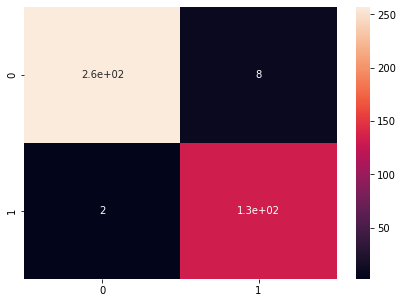

97.5

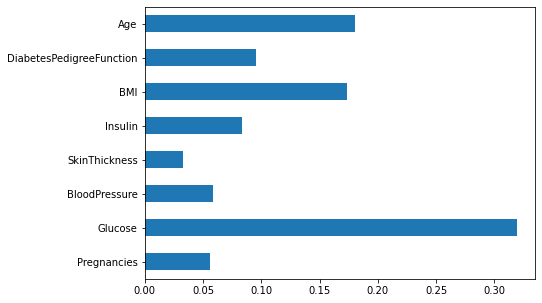

In [238]:
dtree_classifier()


In [239]:
pickle_in_svc = open('svc_classifier.pkl','rb')
svc_classifier = pickle.load(pickle_in_svc)

In [240]:
sc_x = StandardScaler()
input_arr = np.array([8,179.0,72.000000,42.0,130.0,32.7,0.719,36]).reshape(-1,1)
sc_arr = sc_x.fit_transform(input_arr)
sc_arr = sc_arr.reshape(1,8)
prediction = svc_classifier.predict(sc_arr)
print(prediction)

[0]


C:\Users\Santosh Vishwanathan\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [241]:
diab_df_cpy

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0               2    138.0      62.000000           35.0    126.0  33.6   
1               0     84.0      82.000000           31.0    125.0  38.2   
2               0    145.0      72.403665           29.0    126.0  44.2   
3               0    135.0      68.000000           42.0    250.0  42.3   
4               1    139.0      62.000000           41.0    480.0  40.7   
...           ...      ...            ...            ...      ...   ...   
1995            2     75.0      64.000000           24.0     55.0  29.7   
1996            8    179.0      72.000000           42.0    130.0  32.7   
1997            6     85.0      78.000000           29.0    126.0  31.2   
1998            0    129.0     110.000000           46.0    130.0  67.1   
1999            2     81.0      72.000000           15.0     76.0  30.1   

      DiabetesPedigreeFunction  Age  Outcome  
0                        0.127   47        1  
1                        0.233   23        0  
2                        0.630   31        1  
3                        0.365   24        1  
4                        0.536   21        0  
...                        ...  ...      ...  
1995                     0.370   33        0  
1996                     0.719   36        1  
1997                     0.382   42        0  
1998                     0.319   26        1  
1999                     0.547   25        0  

[2000 rows x 9 columns]

In [242]:
diab_df_cpy[diab_df_cpy['Outcome'] == 1]

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0               2    138.0      62.000000           35.0    126.0  33.6   
2               0    145.0      72.403665           29.0    126.0  44.2   
3               0    135.0      68.000000           42.0    250.0  42.3   
11              4    125.0      70.000000           18.0    122.0  28.9   
16              7    195.0      70.000000           33.0    145.0  25.1   
...           ...      ...            ...            ...      ...   ...   
1986            6    104.0      74.000000           18.0    156.0  29.9   
1991            6    102.0      82.000000           29.0    126.0  30.8   
1992            6    134.0      70.000000           23.0    130.0  35.4   
1996            8    179.0      72.000000           42.0    130.0  32.7   
1998            0    129.0     110.000000           46.0    130.0  67.1   

      DiabetesPedigreeFunction  Age  Outcome  
0                        0.127   47        1  
2                        0.630   31        1  
3                        0.365   24        1  
11                       1.144   45        1  
16                       0.163   55        1  
...                        ...  ...      ...  
1986                     0.722   41        1  
1991                     0.180   36        1  
1992                     0.542   29        1  
1996                     0.719   36        1  
1998                     0.319   26        1  

[684 rows x 9 columns]